In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import kagglehub
path = kagglehub.dataset_download("ashishjangra27/doodle-dataset")

In [ ]:
picked_classes = ['The Mona Lisa', 'airplane', 'backpack', 'cake', 'dog',
                  'fish', 'guitar', 'skull', 'traffic light', 'windmill']

In [ ]:
def load_images(path, image_size=(64, 64)):
    X = []
    y = []

    classes = [c for c in os.listdir(path) if c in picked_classes]

    for class_name in classes:
        class_path = os.path.join(path, class_name)
        image_files = os.listdir(class_path)

        for filename in image_files:
            image_path = os.path.join(class_path, filename)

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, image_size)
            image = image / 255
            image = np.where(image <= 0.99, 0.0, 1.0)

            X.append(image)
            y.append(class_name)

    return X, y

X, y = load_images(path + '/doodle')

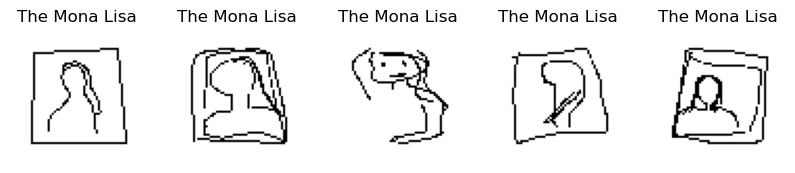

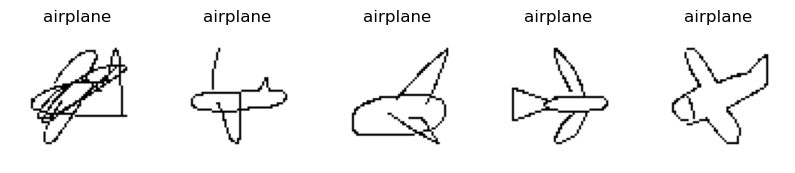

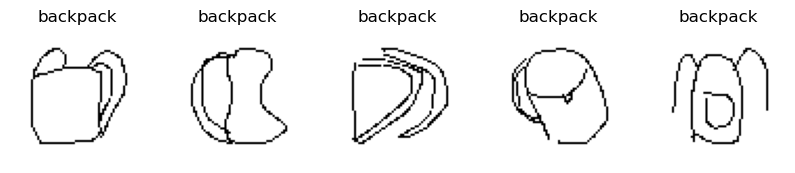

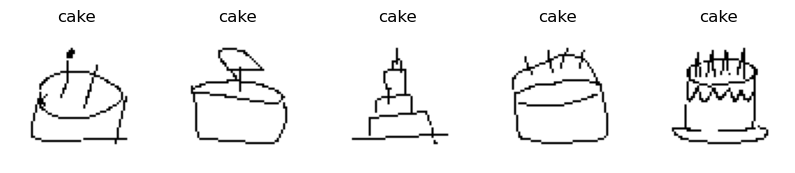

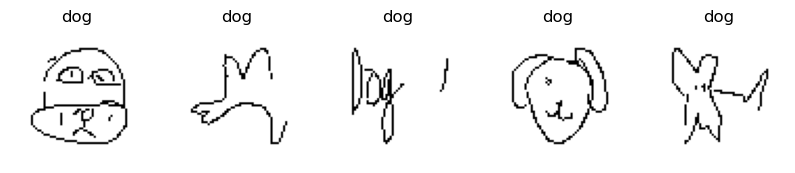

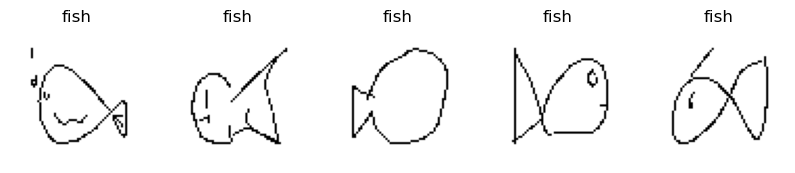

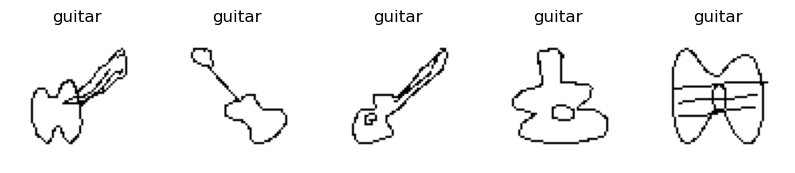

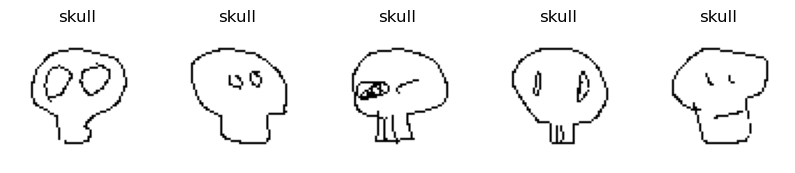

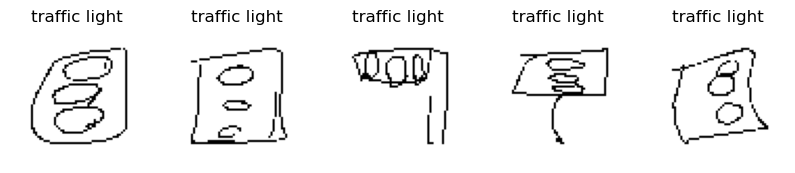

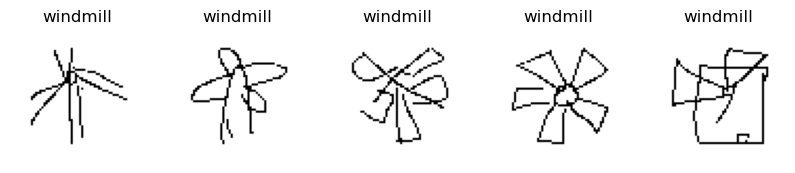

In [ ]:
unique_labels = sorted(set(y))[:10]

for label in unique_labels:
    label_indices = [i for i, l in enumerate(y) if l == label]
    selected_indices = label_indices[:5]

    fig, axes = plt.subplots(1, 5, figsize=(10, 5))

    for i, index in enumerate(selected_indices):
      axes[i].imshow(X[index], cmap='gray')
      axes[i].set_title(f"{label}")
      axes[i].axis('off')

    plt.show()

In [ ]:
def hog_extractor(X, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys'):
    hog_features = []
    hog_images = []

    for image in X:
        features, hog_img = hog(image, orientations=orientations,
                                pixels_per_cell=pixels_per_cell,
                                cells_per_block=cells_per_block,
                                block_norm=block_norm, feature_vector=True,
                                visualize=True)
        hog_features.append(features)
        hog_images.append(hog_img)

    return np.array(hog_features), hog_images

In [ ]:
_, hog_visuals = hog_extractor(X[:3])

In [ ]:
def visualize_features(original, hog):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("HOG")
    plt.imshow(hog, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

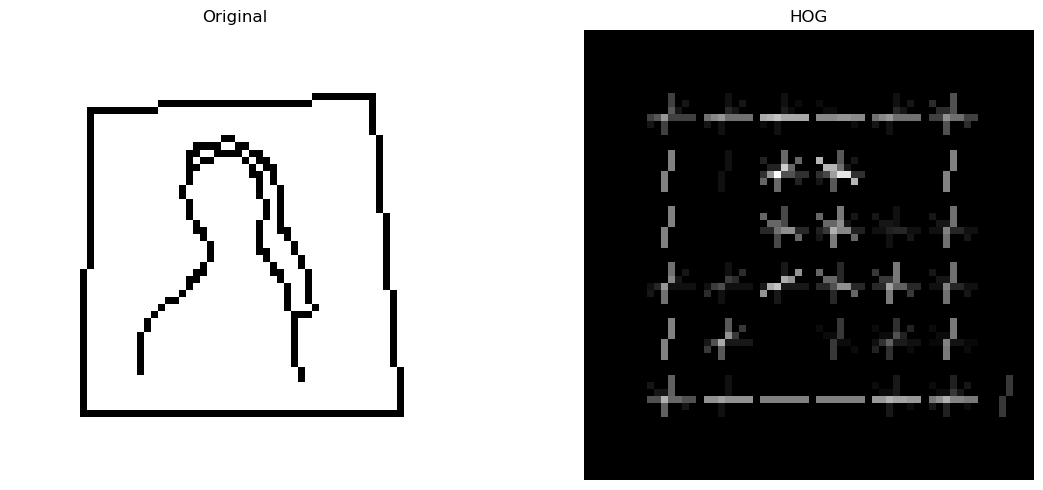

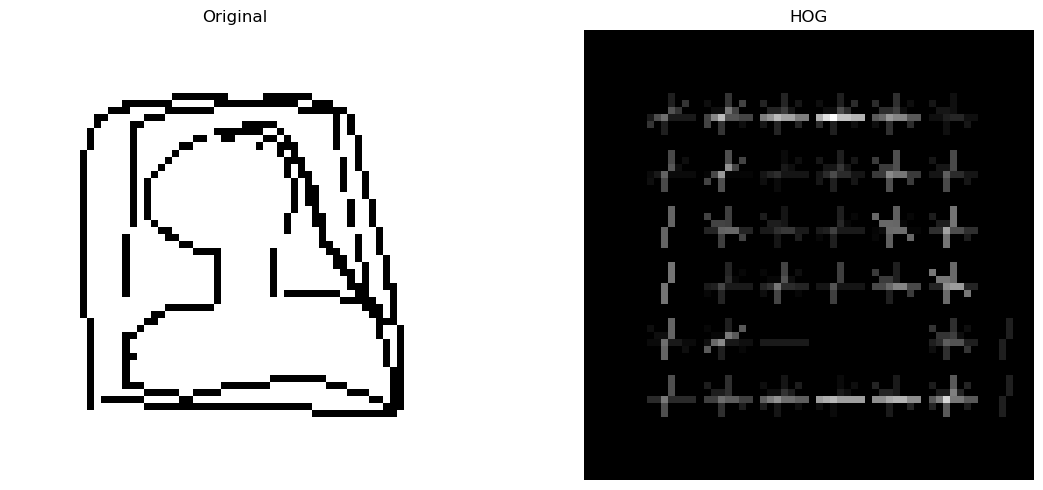

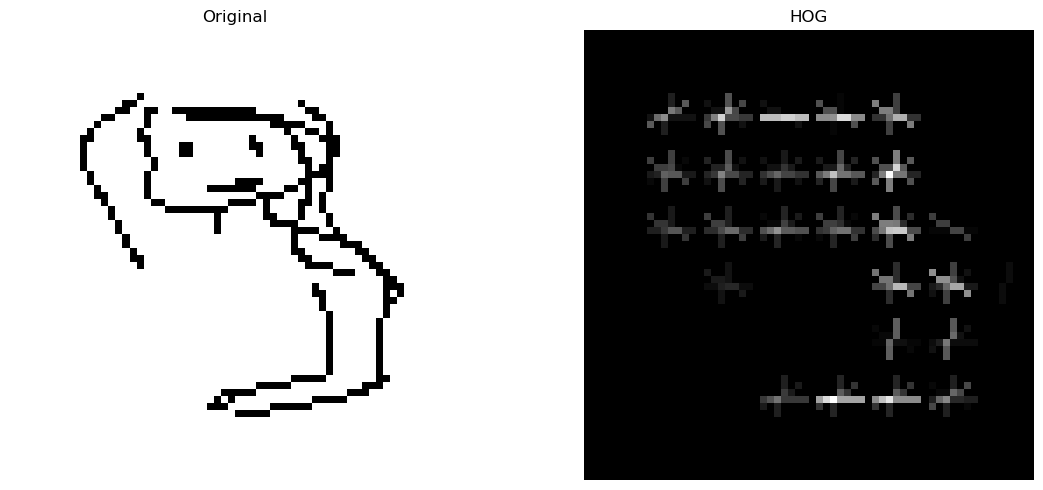

In [ ]:
visualize_features(X[0], hog_visuals[0])
visualize_features(X[1], hog_visuals[1])
visualize_features(X[2], hog_visuals[2])

In [ ]:
def evaluate_model(X_val, y_val, model, le):
    if isinstance(model, keras.Model):
        preds = model.predict(X_val)
        y_pred = np.argmax(preds, axis=1)
    else:
        y_pred = model.predict(X_val)

    true_label = le.inverse_transform(y_val)
    pred_label = le.inverse_transform(y_pred)

    cr = classification_report(true_label, pred_label, digits=4)
    print(cr)

    cm = confusion_matrix(true_label, pred_label)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xticks(rotation=45)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return y_pred, cr, cm

In [ ]:
def visualize_confused_samples(X, y_true, y_pred, cm, le, samples_per_class=5):
    num_classes = cm.shape[0]

    fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))

    for i in range(num_classes):
        incorrect_indices = np.where((y_true == i) & (y_pred != i))[0]

        selected_indices = np.random.choice(incorrect_indices, size=samples_per_class, replace=False)

        for j in range(samples_per_class):
            ax = axs[i, j] if samples_per_class > 1 else axs[i]
            idx = selected_indices[j]
            ax.imshow(X[idx], cmap='gray')

            true_label = le.inverse_transform([y_true[idx]])[0]
            pred_label = le.inverse_transform([y_pred[idx]])[0]

            ax.set_title(f"T: {true_label}\n P: {pred_label}", fontsize=10)
            ax.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [ ]:
np.array(X_train).shape

(21000, 64, 64)

In [ ]:
X_train_hog, _ = hog_extractor(X_train)
X_val_hog, _ = hog_extractor(X_val)

In [ ]:
X_train_hog.shape

(21000, 2916)

In [ ]:
X_train_cnn = np.array(X_train).reshape(-1, 64, 64, 1)
X_val_cnn = np.array(X_val).reshape(-1, 64, 64, 1)

In [ ]:
X_train_cnn.shape

(21000, 64, 64, 1)

# KNN

In [ ]:
pipeline_knn = Pipeline([
    ('pca', PCA()),
    ('knn', KNC())
])

params_knn = {
    'pca__n_components': [50, 100, 150],
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn__weights': ['distance', 'uniform'],
}

In [ ]:
grid_hog_knn = GridSearchCV(pipeline_knn, params_knn, cv=5, scoring='accuracy', n_jobs=5, verbose=4)

grid_hog_knn.fit(X_train_hog, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 3/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=50;, score=0.857 total time=  10.7s
[CV 5/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=50;, score=0.862 total time=  10.7s
[CV 2/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=50;, score=0.855 total time=  10.7s
[CV 4/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=50;, score=0.854 total time=  10.7s
[CV 1/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=50;, score=0.851 total time=  10.8s
[CV 4/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=100;, score=0.873 total time=  12.5s
[CV 3/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=100;, score=0.872 total time=  12.9s
[CV 2/5] END knn__n_neighbors=1, knn__weights=distance, pca__n_components=100;, score=0.869 total time=  13.0s
[CV 1/5] END knn__n_neighbors=1, knn__weights=distance,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'knn__weights': ['distance', 'uniform'],
                         'pca__n_components': [50, 100, 150]},
             scoring='accuracy', verbose=4)

In [ ]:
print(grid_hog_knn.best_params_)
print(grid_hog_knn.best_score_)

{'knn__n_neighbors': 10, 'knn__weights': 'distance', 'pca__n_components': 100}
0.8974761904761905


               precision    recall  f1-score   support

The Mona Lisa     0.8782    0.9211    0.8991       900
     airplane     0.9470    0.8933    0.9194       900
     backpack     0.8768    0.8700    0.8734       900
         cake     0.8919    0.9722    0.9304       900
          dog     0.9031    0.7044    0.7915       900
         fish     0.9774    0.9111    0.9431       900
       guitar     0.8536    0.9589    0.9032       900
        skull     0.8837    0.9711    0.9254       900
traffic light     0.9189    0.8811    0.8996       900
     windmill     0.9107    0.9400    0.9251       900

     accuracy                         0.9023      9000
    macro avg     0.9041    0.9023    0.9010      9000
 weighted avg     0.9041    0.9023    0.9010      9000



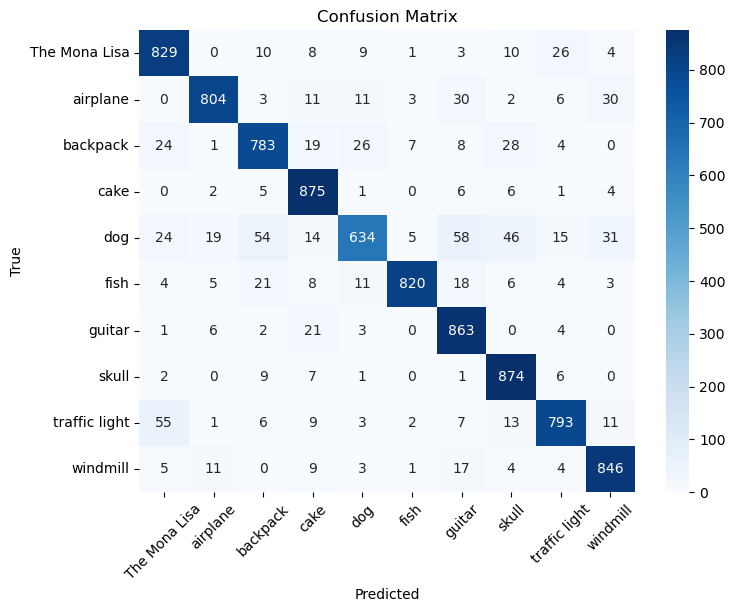

In [ ]:
y_pred_hog_knn, cr_hog_knn, cm_hog_knn = evaluate_model(X_val_hog, y_val, grid_hog_knn.best_estimator_, le)

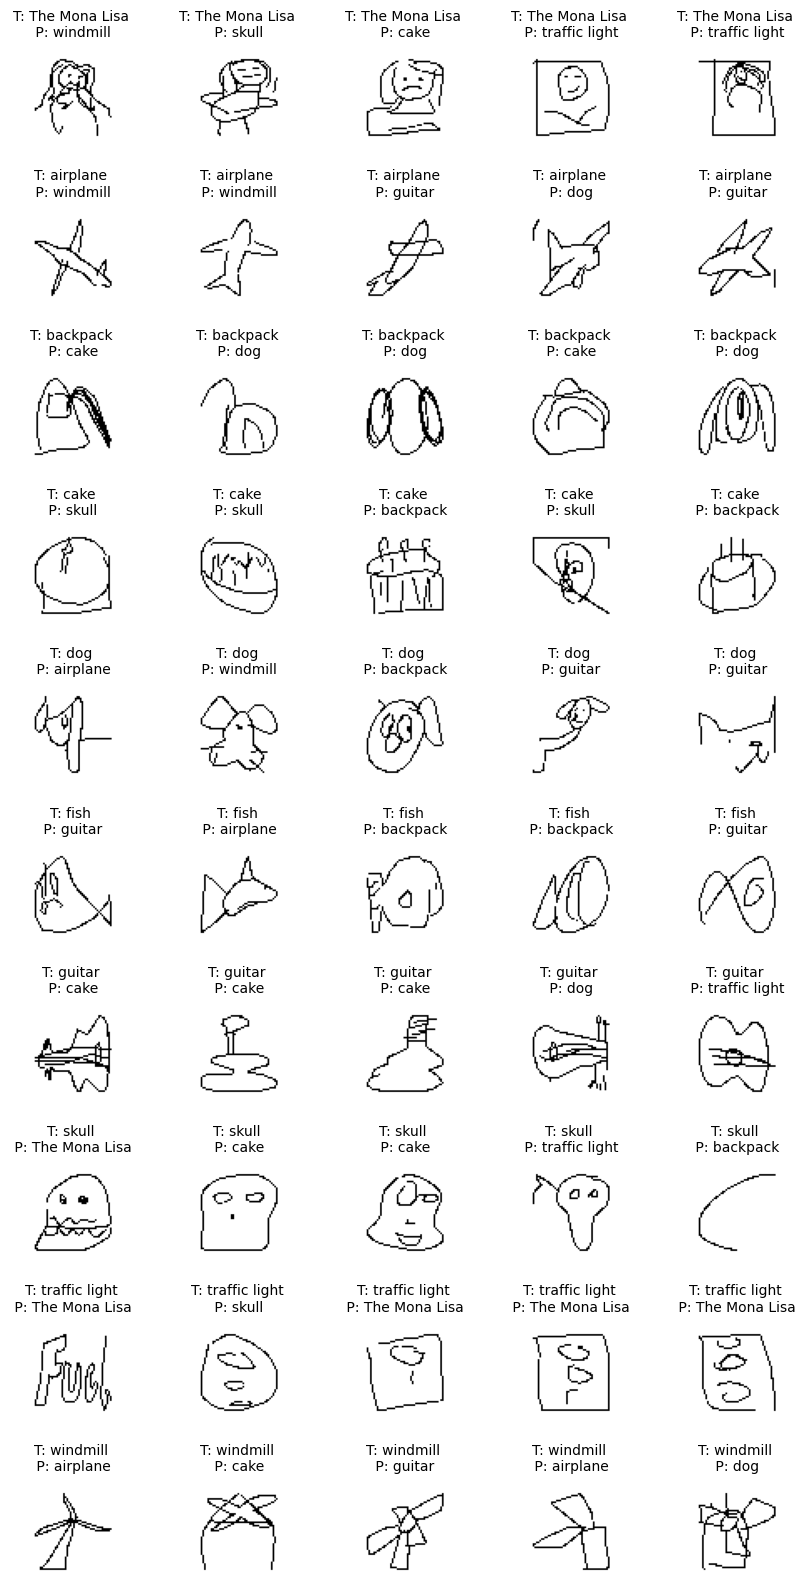

In [ ]:
visualize_confused_samples(X_val, y_val, y_pred_hog_knn, cm_hog_knn, le)

# SVM

In [ ]:
pipeline_svm = Pipeline([
    ('pca', PCA()),
    ('svm', SVC(decision_function_shape='ovr', gamma='scale'))
])

params_svm = {
    'pca__n_components': [100, 150, 200],
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [1, 10, 100, 200],
}

In [ ]:
grid_hog_svm = GridSearchCV(pipeline_svm, params_svm, cv=5, scoring='accuracy', n_jobs=5, verbose=4)

grid_hog_svm.fit(X_train_hog, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 2/5] END pca__n_components=100, svm__C=1, svm__kernel=linear;, score=0.875 total time=  19.9s
[CV 5/5] END pca__n_components=100, svm__C=1, svm__kernel=linear;, score=0.879 total time=  21.0s
[CV 3/5] END pca__n_components=100, svm__C=1, svm__kernel=linear;, score=0.881 total time=  21.1s
[CV 4/5] END pca__n_components=100, svm__C=1, svm__kernel=linear;, score=0.877 total time=  21.6s
[CV 1/5] END pca__n_components=100, svm__C=1, svm__kernel=linear;, score=0.865 total time=  27.2s
[CV 3/5] END pca__n_components=100, svm__C=1, svm__kernel=rbf;, score=0.931 total time=  22.7s
[CV 2/5] END pca__n_components=100, svm__C=1, svm__kernel=rbf;, score=0.927 total time=  27.0s
[CV 4/5] END pca__n_components=100, svm__C=1, svm__kernel=rbf;, score=0.925 total time=  30.2s
[CV 1/5] END pca__n_components=100, svm__C=1, svm__kernel=rbf;, score=0.925 total time=  33.6s
[CV 5/5] END pca__n_components=100, svm__C=1, svm__kernel=rbf;, scor

GridSearchCV(cv=5, estimator=Pipeline(steps=[('pca', PCA()), ('svm', SVC())]),
             n_jobs=5,
             param_grid={'pca__n_components': [100, 150, 200],
                         'svm__C': [1, 10, 100, 200],
                         'svm__kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=4)

In [ ]:
print(grid_hog_svm.best_params_)
print(grid_hog_svm.best_score_)

{'pca__n_components': 150, 'svm__C': 10, 'svm__kernel': 'rbf'}
0.9303809523809523


               precision    recall  f1-score   support

The Mona Lisa     0.9449    0.9333    0.9391       900
     airplane     0.9381    0.9433    0.9407       900
     backpack     0.8961    0.9200    0.9079       900
         cake     0.9581    0.9667    0.9624       900
          dog     0.8547    0.8756    0.8650       900
         fish     0.9667    0.9367    0.9515       900
       guitar     0.9652    0.9567    0.9609       900
        skull     0.9622    0.9611    0.9616       900
traffic light     0.9341    0.9289    0.9315       900
     windmill     0.9653    0.9589    0.9621       900

     accuracy                         0.9381      9000
    macro avg     0.9385    0.9381    0.9383      9000
 weighted avg     0.9385    0.9381    0.9383      9000



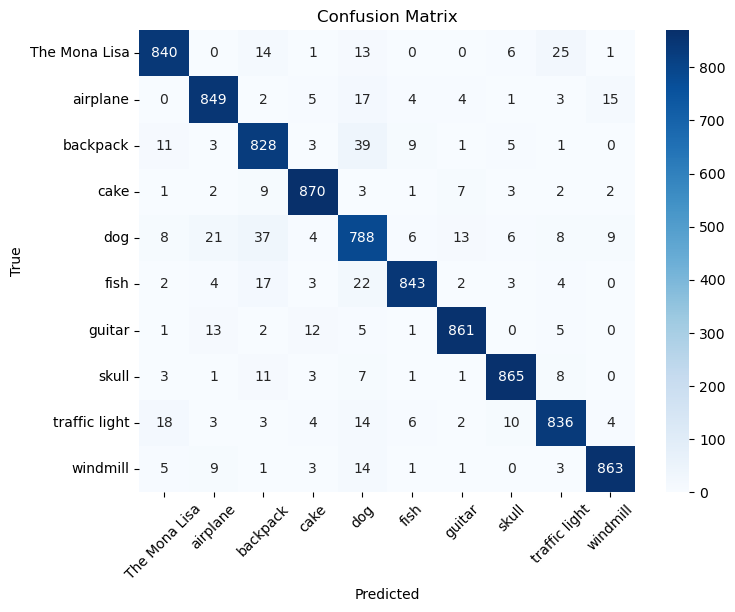

In [ ]:
y_pred_hog_svm, cr_hog_svm, cm_hog_svm = evaluate_model(X_val_hog, y_val, grid_hog_svm.best_estimator_, le)

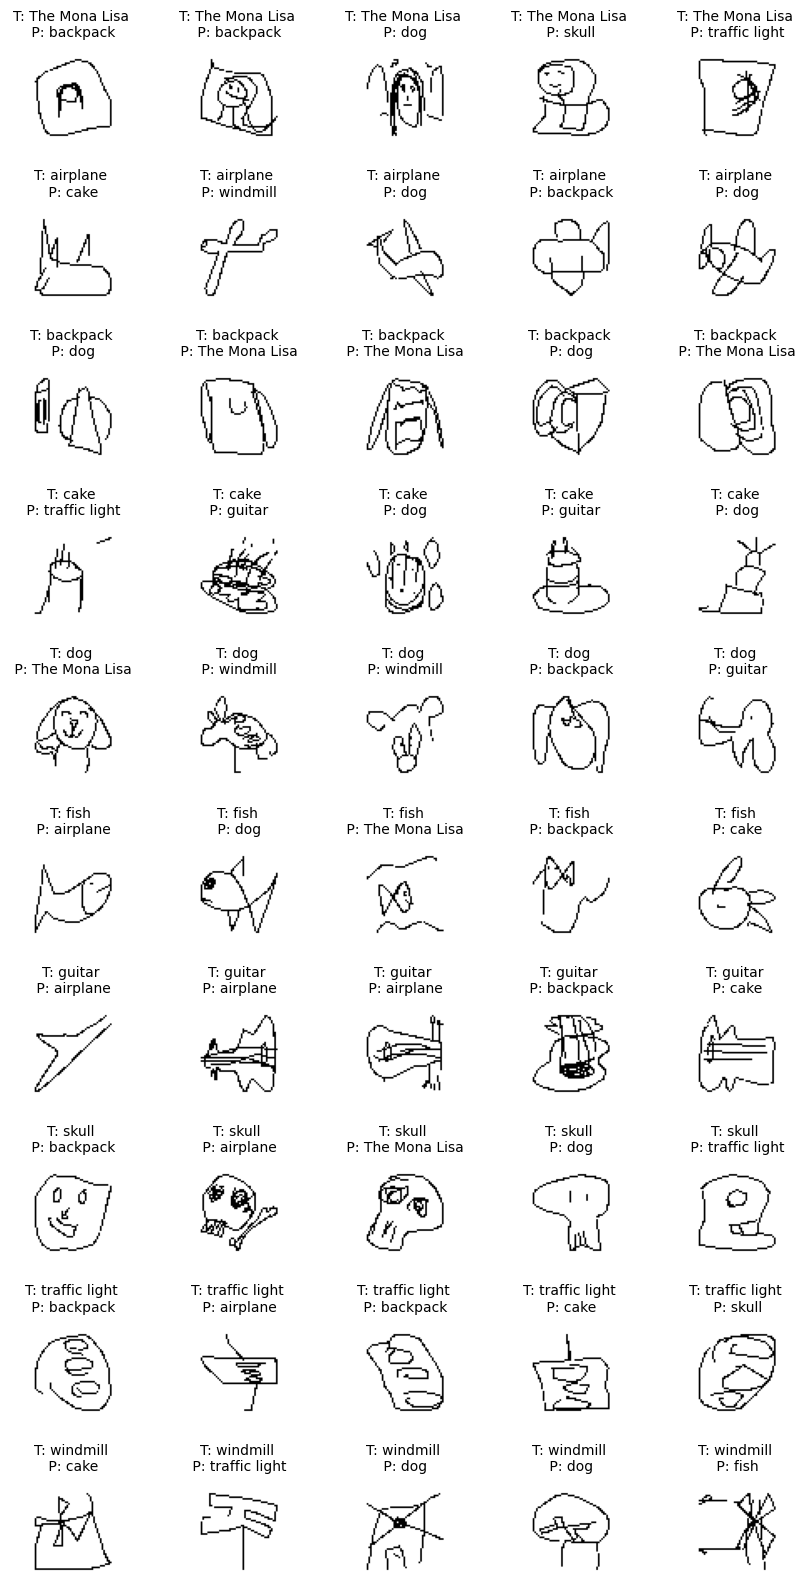

In [ ]:
visualize_confused_samples(X_val, y_val, y_pred_hog_svm, cm_hog_svm, le)

# CNN

In [ ]:
cnn = keras.Sequential([
    layers.Input(shape=(64, 64, 1)),

    layers.Conv2D(16, (3, 3), activation=layers.LeakyReLU(), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), activation=layers.LeakyReLU(), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU(), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation=layers.LeakyReLU()),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])


cnn.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.AdamW())

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1, verbose=1)

cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,002 (2.09 MB)

 Trainable params: 549,002 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), callbacks=[early_stopping, lr_scheduler], epochs=20, verbose=1)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.6584 - loss: 1.0081 - val_accuracy: 0.9077 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8992 - loss: 0.3202 - val_accuracy: 0.9292 - val_loss: 0.2310 - learning_rate: 0.0010
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9228 - loss: 0.2378 - val_accuracy: 0.9368 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9388 - loss: 0.1890 - val_accuracy: 0.9389 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.9459 - loss: 0.1584 - val_accuracy: 0.9454 - val_loss: 0.1875 - learning_rate: 0.0010
Epoch 6/20
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9558 - loss: 0.1389
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9558 - los

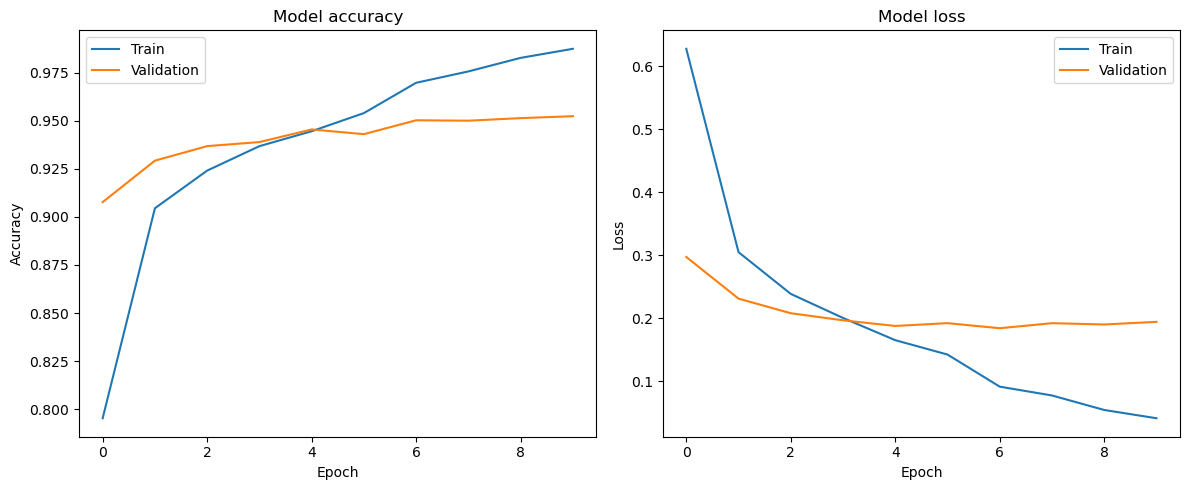

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
               precision    recall  f1-score   support

The Mona Lisa     0.9570    0.9400    0.9484       900
     airplane     0.9389    0.9567    0.9477       900
     backpack     0.9308    0.9267    0.9287       900
         cake     0.9797    0.9644    0.9720       900
          dog     0.9052    0.8911    0.8981       900
         fish     0.9311    0.9611    0.9459       900
       guitar     0.9549    0.9644    0.9596       900
        skull     0.9757    0.9833    0.9795       900
traffic light     0.9649    0.9467    0.9557       900
     windmill     0.9646    0.9678    0.9662       900

     accuracy                         0.9502      9000
    macro avg     0.9503    0.9502    0.9502      9000
 weighted avg     0.9503    0.9502    0.9502      9000



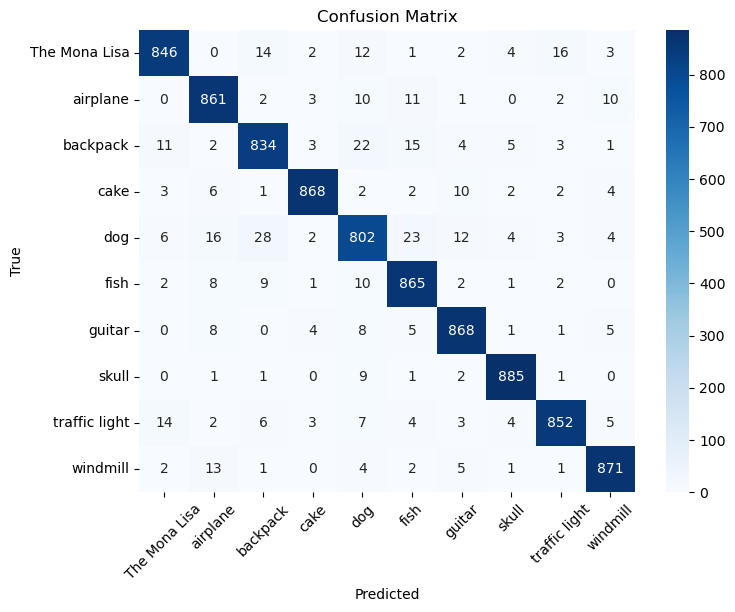

In [ ]:
y_pred_cnn, cr_cnn, cm_cnn = evaluate_model(X_val_cnn, y_val, cnn, le)

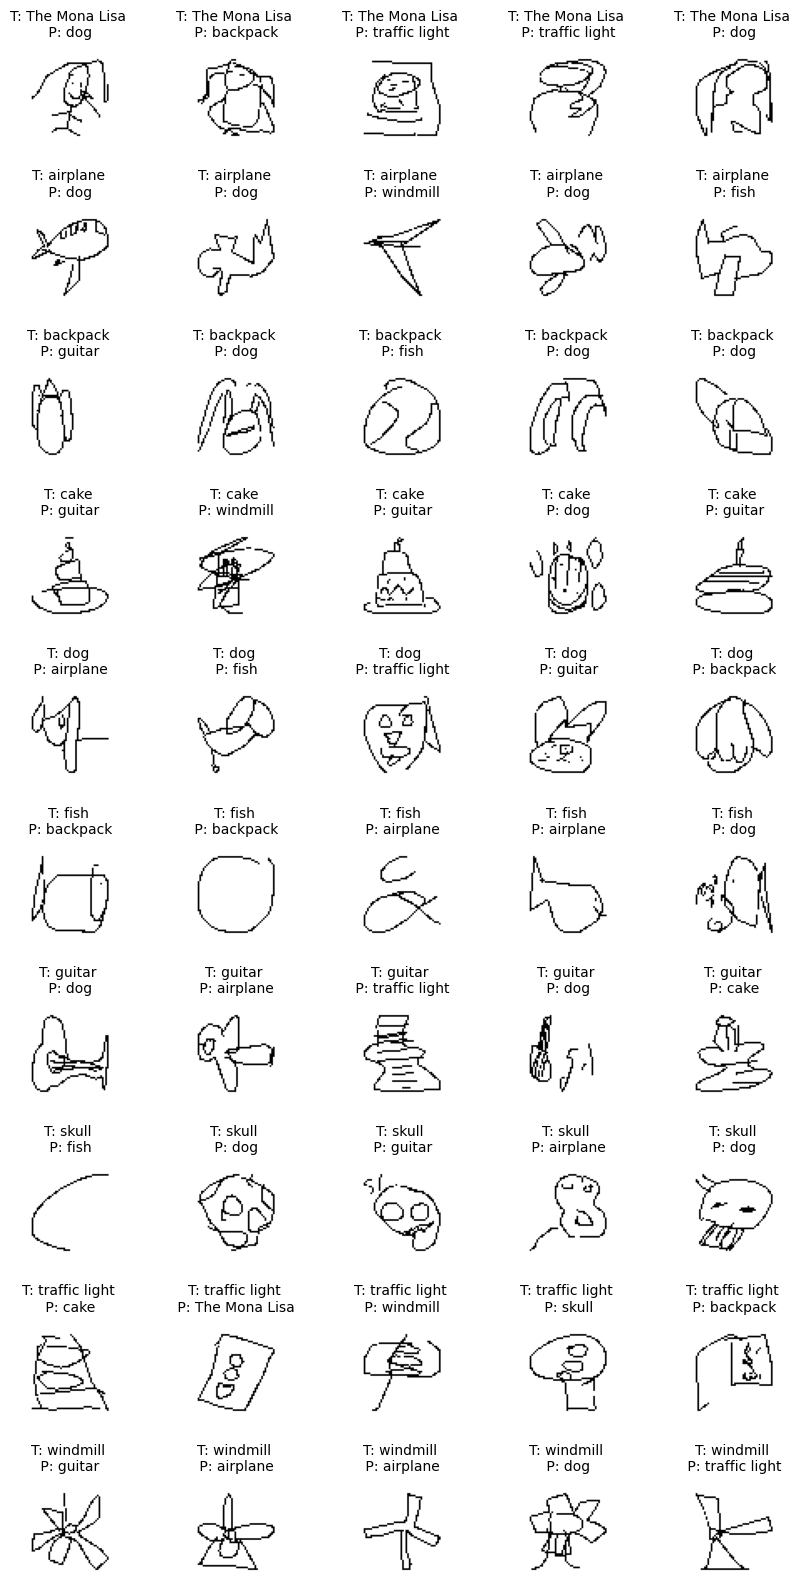

In [ ]:
visualize_confused_samples(X_val, y_val, y_pred_cnn, cm_cnn, le)

In [ ]:
keras.models.save_model(cnn, 'cnn.keras')